# MechWolf: Continuous flow process description, analysis, and automation made easy

MechWolf is a Python framework for automating continuous flow processes.
It was developed as a collaboration between computer scientists, chemists, and complete novices to be used by anyone wanting to do better, faster, more reproducible flow-based science.
Features include:

- Natural language description, analysis, and visualization of continuous flow networks
- Automated execution of protocols
- Full user extensibility
- Smart default settings, designed by scientists for scientists
- Extensive checking to prevent potentially costly and dangerous errors *before* runtime
- Natural language parsing of times and quantities
- Thorough documentation and tutorials


### What does "MechWolf" even mean?

Simply, "MechWolf" is an anagram of "flow chem". This tool can do so much more
than just chemistry automation, so we decided not to pigeonhole ourselves by
calling the project "flow chem".  We like to think MechWolf is a **way** cooler
name anyway.

### Table of Contents

- [About Mechwolf](about/about.rst)
- [User Guide](guide/guide.rst)
- [API Reference](api/api.rst)
- [CLI Reference](cli/cli.rst)
- [Contributing](contributing.md)

### Three Minutes to MechWolf


Let's say you're trying to automate the production of [acetaminophen](https://en.wikipedia.org/wiki/Paracetamol), a popular pain reliever and fever
reducer. The reaction involves combining two chemicals, 4-aminophenol and acetic
anhydride. The basic level of organization in MechWolf are individual
components, such as the vessels and pumps. Let's go ahead and create them:

In [1]:
import mechwolf as mw

# define the vessels
aminophenol = mw.Vessel(description="15 mL `4-aminophenol`", name="aminophenol")
acetic_anhydride = mw.Vessel("15 mL `acetic anhydride`", name="acetic anhydride")
acetaminophen = mw.Vessel("`acetaminophen`", name="acetaminophen")

# define the pumps
pump_1 = mw.Pump(name="pump_1")
pump_2 = mw.Pump(name="pump_2")

# define the mixer
mixer = mw.TMixer()

That wasn’t too bad! Just as putting vessels and pumps on a lab bench doesn’t actually do anything, we’re going to need to tell MechWolf what the configuration of the components is. The ` symbols are there to surround chemical names that we want resolved; we’ll see how that works shortly.

We can do this by creating an `Apparatus` object. To add connections between components, we need to tell MechWolf three things: where the connection is from, where it’s going, and how they are actually connected. Tubing type can have a significant effect on reproducibility, so we require that you explicitly specify what tubing you are using when connecting components. This sounds complicated, but it is actually easy in practice:

In [2]:
# same tube specs for all tubes
tube = mw.Tube(length="1 m", ID="1/16 in", OD="2/16 in", material="PVC")

# create the Apparatus object
A = mw.Apparatus()

# add the connections
A.add(aminophenol, pump_1, tube)  # connect aminophenol vessel to pump_1
A.add(acetic_anhydride, pump_2, tube)  # connect acetic_anhydride vessel to pump_2
A.add([pump_1, pump_2], mixer, tube)  # connect pump_1 and pump_2 to mixer
A.add(mixer, acetaminophen, tube)  # connect mixer to the output vessel

With the Apparatus object, we can do so much. If we call `summarize()`, we’ll get a clean tabular describe of our apparatus like this with summary values automatically computed:

In [3]:
A.summarize()

But wait, there’s more! `visualize()` will create a diagram of the network:

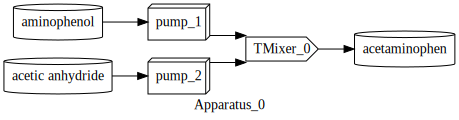

In [4]:
A.visualize()

It’s fully customizable, so you can decide whether to show the details of the tubing, the name of the apparatus, and more. And that’s not all either. `describe()` will generate an SI-ready description of the apparatus:

In [5]:
A.describe()

A vessel containing 15 mL 4-aminophenol was connected to Pump pump_1 using PVC tubing (length 1 meter, ID 0.0625 inch, OD 0.125 inch). A vessel containing 15 mL acetic anhydride (Acetyl acetate) was connected to Pump pump_2 using PVC tubing (length 1 meter, ID 0.0625 inch, OD 0.125 inch). Pump pump_1 was connected to TMixer TMixer_0 using PVC tubing (length 1 meter, ID 0.0625 inch, OD 0.125 inch). Pump pump_2 was connected to TMixer TMixer_0 using PVC tubing (length 1 meter, ID 0.0625 inch, OD 0.125 inch). TMixer TMixer_0 was connected to a vessel containing acetaminophen (N-(4-Hydroxyphenyl)acetamide) using PVC tubing (length 1 meter, ID 0.0625 inch, OD 0.125 inch). 

Note that chemical names were automatically resolved to their IUPAC names. That’s because the ` symbols around the chemical name tell MechWolf to use the National Cancer Institute’s resolver.

Now that we’ve gone over how to define an apparatus and all the different ways to inspect it, let’s make it synthesize acetaminophen. We do that with a `Protocol`, a list of procedures defined for an `Apparatus`. For this reaction, it’s as simple as deciding the flow rate and duration for which to run the pumps:

In [6]:
# create the Protocol object
P = mw.Protocol(A, name="acetaminophen synthesis")
P.add([pump_1, pump_2], duration="15 seconds", rate="1 mL/min")

It’s really that simple to create protocols. We can visualize it equally simply with `visualize()`:

In [7]:
P.visualize()

Since we have a good idea of what our protocol is going to do, let’s go ahead and compile it. This will convert the procedure we added to the protocol into a list of instructions that can be passed to the components. We can compile it directly with `compile()` but let’s get it in YAML format for the sake of readability by calling `yaml()`:

In [8]:
P.yaml()

- component: pump_1
  params:
    rate: 1 mL/min
  start: 0.0
  stop: 15.0
- component: pump_2
  params:
    rate: 1 mL/min
  start: 0.0
  stop: 15.0

Just as we expect, the pumps will both turn on to 1 mL/min at time 0 and turn off 900 seconds (15 minutes) later. When we’re ready to actually execute the protocol, we just call `execute()` and MechWolf will do the rest, ensuring that both pumps have their protocols and start in sync.

In [9]:
P.execute(dry_run=True)

<Experiment 2019_07_04_22_49_53_6007a857>